In [85]:
%matplotlib inline
import re
import pandas as pd
import requests
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly as py
import seaborn as sbn
import textatistic
from bs4 import BeautifulSoup
matplotlib.style.use('ggplot')
import psycopg2
py.offline.init_notebook_mode()

In [86]:
catalog = requests.get('https://www.luther.edu/catalog/curriculum')
# db3 = pd.read_json('/home/faculty/millbr02/pub/course_data.json')

In [87]:
soup = BeautifulSoup(catalog.text, 'html.parser')


In [88]:
dept_list = soup.select('ul.childrenList a')
majors = []
for item in dept_list:
    dept = item.get('href', 'None')
    if dept != 'None':
        majors.append(dept)

In [89]:
df = pd.DataFrame(columns=['Dept', 'CourseName', 'CourseNumber', 'Hours', 'GenEds', 'Prereqs', 'Description'])


In [90]:
sites =[]
for item in majors:
    x = 'https://www.luther.edu/catalog/curriculum/{}'.format(item)
    sites.append(x)

In [91]:
def find_classes(cup_of_soup,row):
    department = cup_of_soup.find_all('h1', class_='pageTitle')[0].text
    courses = cup_of_soup.find_all('div', class_='courseContainer')
    for item in courses:
        course_title = item.find_all('span', class_='courseTitle')[0].text
        course_number = item.find_all('span', class_='courseNumber')[0].text
        credit_hours = item.find_all('li')[0].text
        for part in item.find_all('li'):
            if part.find_all('i', class_='fa-li fa fa-book fa-lg') != []:
                prereqs = part.text.split(' ')[1:]
                prereqs = ' '.join(prereqs)
            else:
                prereqs = ''
        description = item.find_all('span', class_='courseDescription')[0].text
        geneds = []
        for content in item.find_all('span', class_='genEd'):
            geneds.append(content.text)
        gened_string = ', '.join(geneds)
        df.loc[row] = [department, course_title, course_number, credit_hours, gened_string, prereqs, description]
        row += 1
    return row

In [92]:

row = 0
for item in majors:
    this_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(item))
    soup = BeautifulSoup(this_course.text, 'html.parser')
    row = find_classes(soup, row)

In [93]:
df.head()

Dept                    CourseName CourseNumber    Hours GenEds  \
0  Accounting    Introduction to Accounting    ACCTG 110  2 hours          
1  Accounting    Fundamentals of Accounting    ACCTG 150  4 hours          
2  Accounting  Managerial Cost Accounting I    ACCTG 250  4 hours          
3  Accounting     Intermediate Accounting I    ACCTG 353  4 hours          
4  Accounting    Intermediate Accounting II    ACCTG 354  4 hours          

                            Prereqs  \
0  First-year or sophomore standing   
1                         ACCTG 110   
2                         ACCTG 150   
3     ACCTG 250 and junior standing   
4                         ACCTG 353   

                                         Description  
0  A course specifically for students who have ha...  
1  The course provides a basic understanding of f...  
2  This course examines the central role of manag...  
3  Deals with financial accounting concepts and p...  
4  Further coverage of financial accounting conce...

In [94]:

list1 = []
list2 = []
import re
for item in df.Prereqs:
    list1.append(re.findall(r'[A-Z][A-Z][A-Z]+', item))
for item in list1:
    list2.append(item)
    
df2 = pd.DataFrame(columns= ['abbv', 'relations'])

df2['abbv'] = df.CourseNumber.map(lambda x : x.split(' ')[0])

df2['relations'] = list2
df2.head()

abbv relations
0  ACCTG        []
1  ACCTG   [ACCTG]
2  ACCTG   [ACCTG]
3  ACCTG   [ACCTG]
4  ACCTG   [ACCTG]

In [95]:
s = df2.relations.apply(pd.Series).stack().reset_index(level =1, drop=True)

s.name = 'relation'

df2 = df2.drop('relations', axis=1).join(s)

df2 = df2.reset_index(drop = True)

df2 = df2.drop_duplicates()

df2 = df2.reset_index(drop = True)
df2.head()

abbv relation
0  ACCTG      NaN
1  ACCTG    ACCTG
2   AFRS      NaN
3   AFRS     PAID
4   AFRS      SOC

In [96]:
try:
    for item in majors:
        this_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(item))
        soup = BeautifulSoup(this_course.text, 'html.parser')
        list3 = []
        if soup.find_all('h1', class_='pageTitle')[0].text != 'Nordic Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Library and Information Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Biblical Languages' and soup.find_all('h1', class_='pageTitle')[0].text != 'International Business':
            this = soup.find_all('div', class_='catalog_block')
            that = soup.find_all('span', class_='courseNumber')[0].text
        else:
            pass
        for item in this:
            item = item.text
            list3.append(item)
        if len(that) > 1 :
            that = that.split(' ')
        that.pop()
        that = ''.join(that)
        list4 = []
        for item in list3:
            list4.append(re.findall(r'[A-Z][A-Z]+ [0-9]+', item))
        combining = [item for sublist in list4 for item in sublist]
        lst = []
        for item in combining:
            item = item.split(' ')
            lst.append(item)

        for item in lst:
            del item[1]
        lst = [item for sublist in lst for item in sublist]
        lst = set(lst)
        lst = list(lst)
        df2.set_value(-1, 'abbv', that)
        df2.set_value(-1, 'relation', lst)
        df2 = df2.reset_index(drop=True)
except:
    print(item)

In [97]:
s = df2.relation.apply(pd.Series).stack().reset_index(level = 1, drop=True)

s.name = 'relations'

df2 = df2.drop('relation', axis=1).join(s)

df2 = df2.drop_duplicates()

df2 = df2.sort_values(by=['abbv'])

df2 = df2.replace('', np.nan, regex=True)

df2 = df2.replace('^AND', np.nan, regex=True)

df2 = df2.dropna(how='any')

df2 = df2.reset_index(drop = True)
df2.head()

abbv relations
0  ACCTG       MGT
1  ACCTG       SOC
2  ACCTG      MATH
3  ACCTG      ECON
4  ACCTG      POLS

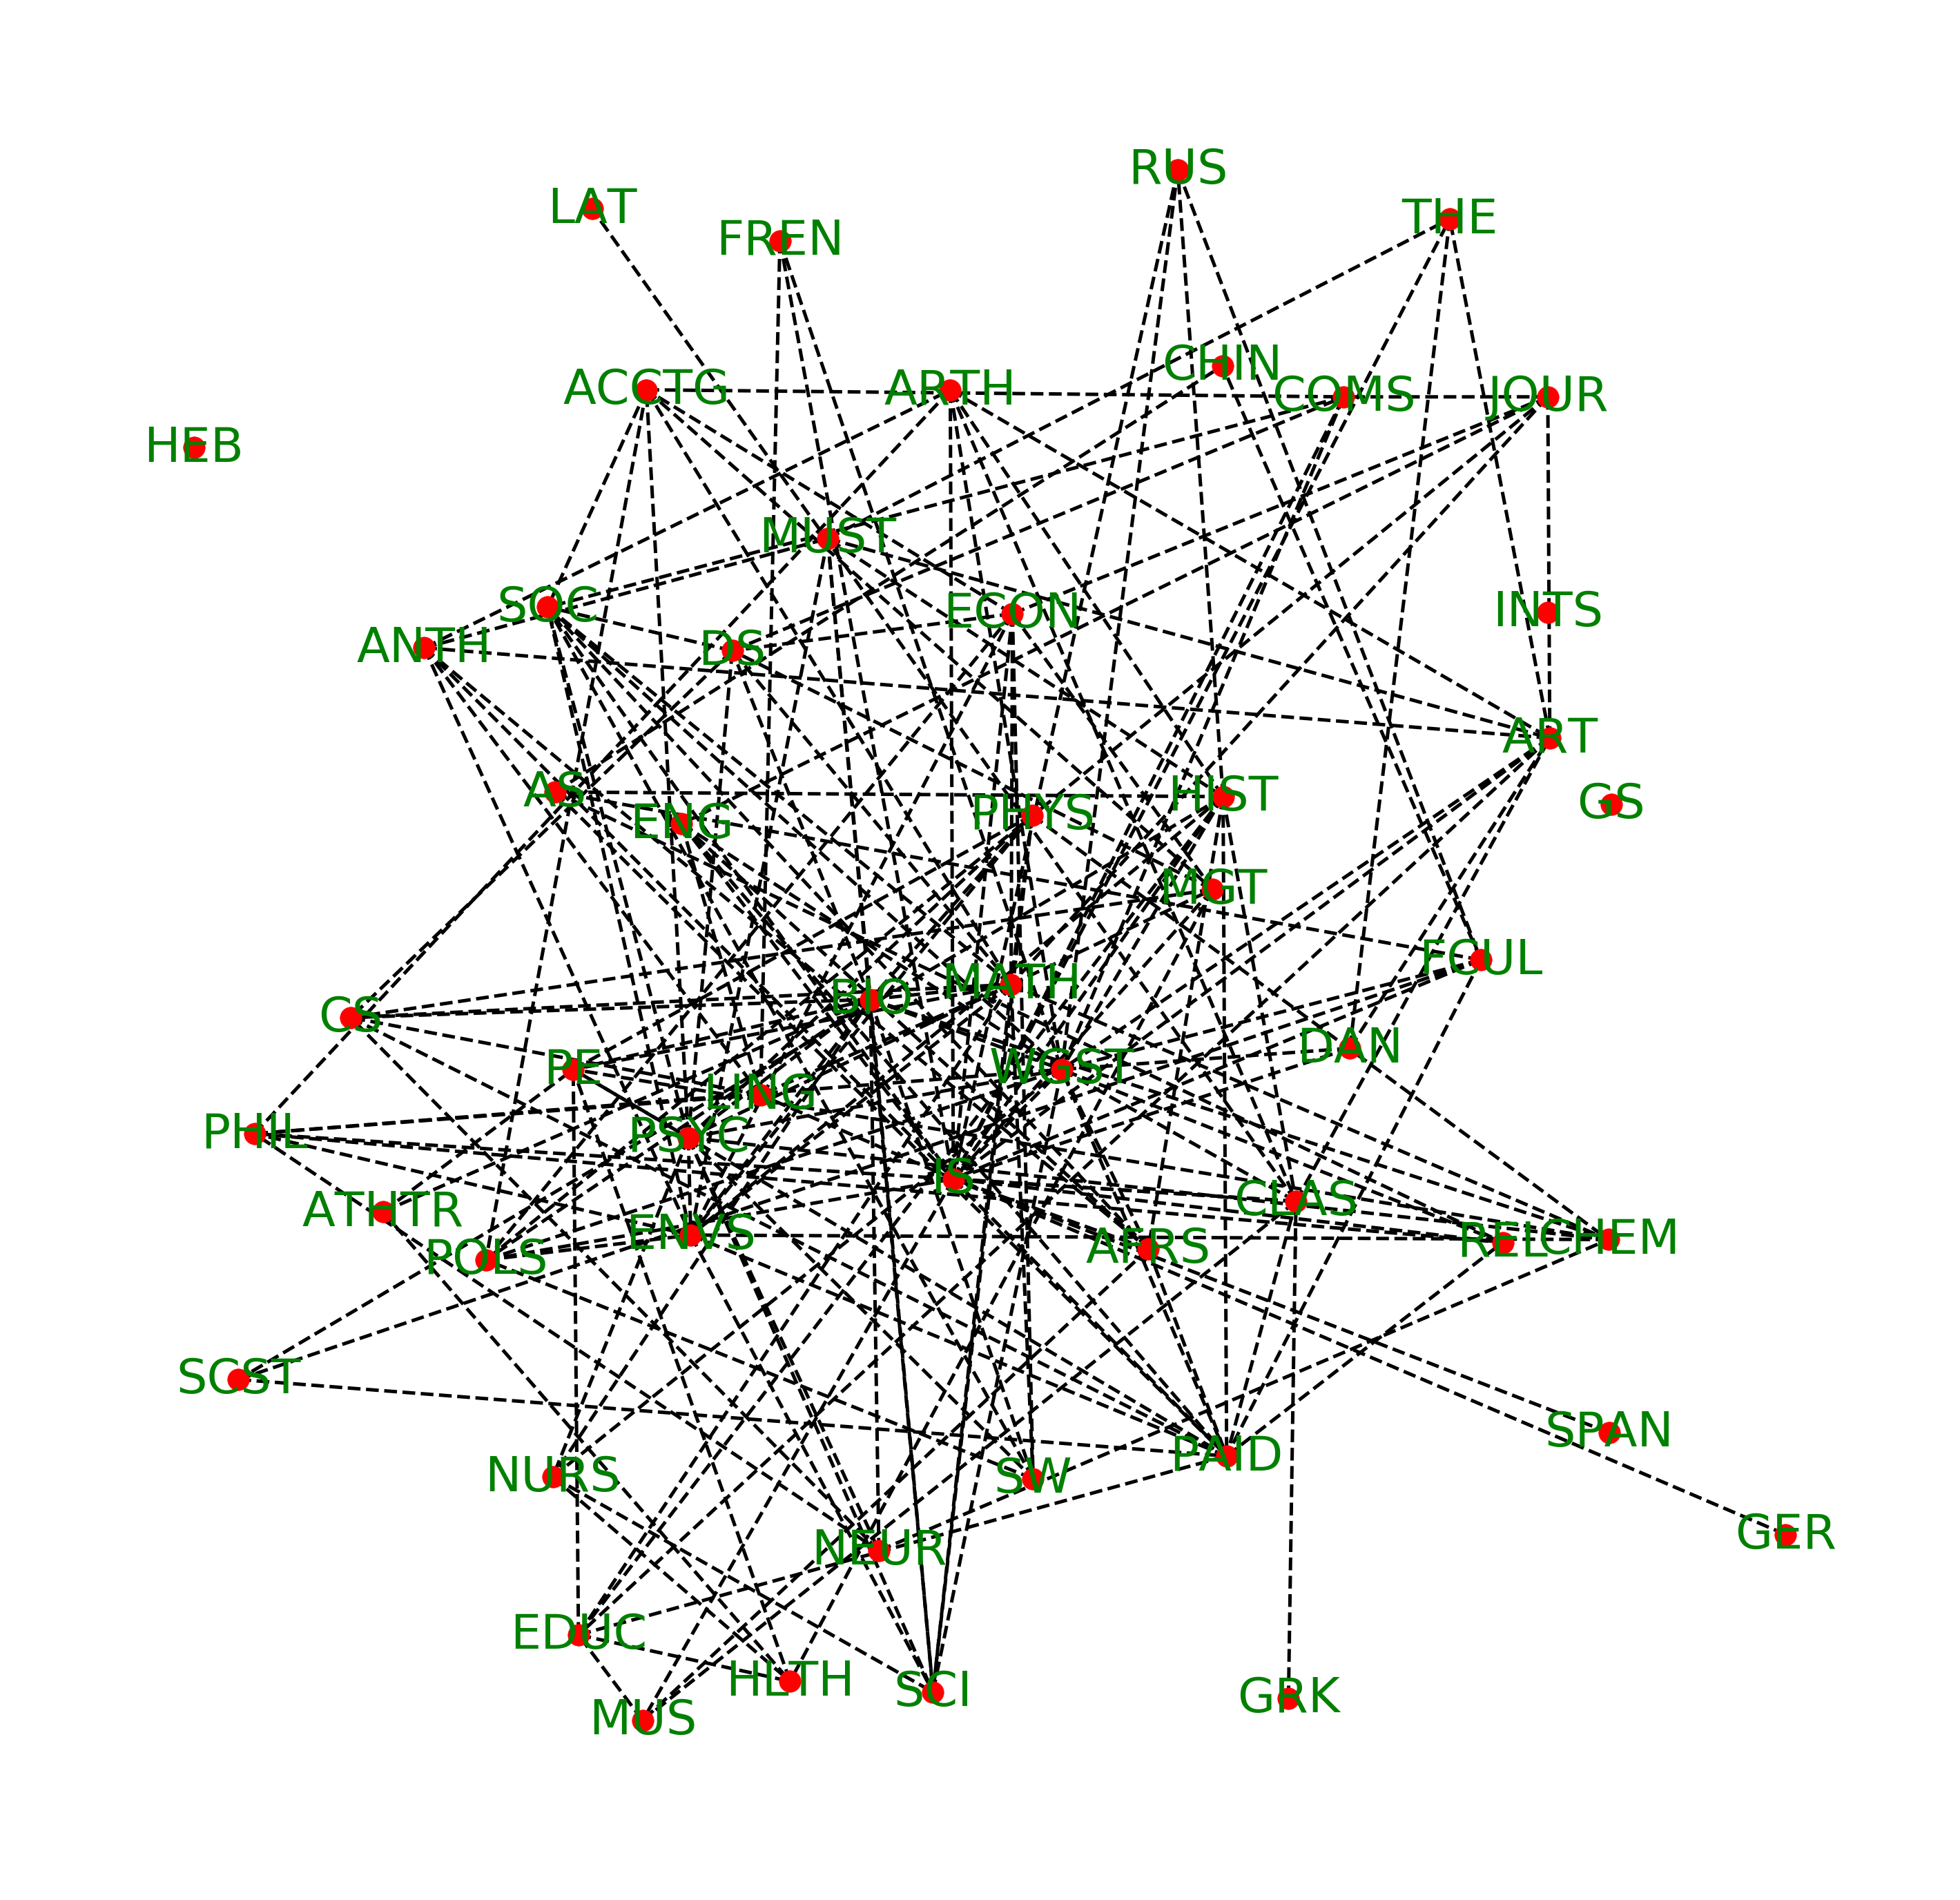

In [98]:
#create a network showing prerequisites in common and connections between departments
g = nx.Graph()
g.add_nodes_from(df2.abbv)


for index, row in df2.iterrows():
    g.add_edge(row['abbv'], row['relations'])
        
gfig, gax = plt.subplots(figsize = (50,50))
nx.draw(g,nx.spring_layout(g, k=0.4, iterations = 5), ax=gax, with_labels = True, font_size = 70, style='dashed', font_color='green', node_size = 1000, width=5)

In [102]:
df2.groupby('relations')['abbv'].count().sort_values(ascending=False)


relations
WGST     18
MATH     18
PAID     15
BIO      14
HIST     12
ART      10
PSYC     10
ECON      9
SOC       9
POLS      9
AFRS      8
PHIL      8
COMS      7
SCI       7
PHYS      7
MGT       7
ANTH      7
CS        6
EDUC      6
CHEM      6
ENVS      6
THE       5
ENG       5
FCUL      5
HLTH      5
REL       5
MUS       5
DAN       4
LING      4
CLAS      4
PE        4
ARTH      3
RUS       3
FREN      3
CHIN      3
NEUR      3
NURS      2
SPAN      2
SCST      2
ACCTG     2
DS        2
LAT       2
GER       2
GRK       2
IS        1
MUST      1
ATHTR     1
AS        1
GS        1
HEB       1
JOUR      1
SW        1
INTS      1
Name: abbv, dtype: int64

In [100]:
df2[df2.relations == 'MATH']

abbv relations
2    ACCTG      MATH
45     BIO      MATH
50    CHEM      MATH
67      CS      MATH
73      DS      MATH
84    ECON      MATH
89    EDUC      MATH
104   ENVS      MATH
158   JOUR      MATH
166   LING      MATH
174   MATH      MATH
181    MGT      MATH
209     PE      MATH
219   PHYS      MATH
224   PSYC      MATH
245    SCI      MATH
255    SOC      MATH
260     SW      MATH